## Overview 
The dataset we chose contains car evaluation data derived from a hierarchical decision model developed initially for a demonstration of a decision making model and can be found at https://archive.ics.uci.edu/ml/datasets/Car+Evaluation. The authors The dataset contains 6 attributes related to either price or technical characteristics. The 7th attribute represents the estimated class of the car and is based on all other attributes. The dataset consists of 1728 entries and is stripped of structural attributes, which means all attributes are directly related to the estimated car class attribute. There are also three intermediate attributes – PRICE, TECH and COMFORT – which are related to the 6 main attributes.  
## Use case
Choosing a vehicle to purchase can be a tedious process that involves hours of research, with studies showing American drivers spend an average of around 15 hours between realizing the need for a new car and making the purchase [1]. 60% of this time is usually spent in online research of specifications and availability. Generally, although the most important attribute of a car is its ability to transport, the final decision is very often based on an amalgam of its price, safety and capacity. The main purpose for the collection of the dataset we chose was to “actively support the decision maker in the knowledge acquisition and evaluation stages of the decision making process” [2]. 
## Prediction task
The dataset uses a simple hierarchical model to classify cars in one of 4 categories: Unacceptable (unacc), Acceptable (acc), Good (good), Very Good (vgood). The criteria tree is displayed below. The goal of our prediction task is to correctly identify the class associated with the car based on the 6 attributes that are used in the evaluation model, without specifying the model structure itself. 
This could be useful in many different scenarios, such as online-based automotive research and shopping websites. Those often imply mathematical algorithms to present users with a nominal rating ranging 

 

<img src='tree.png' label="Criteria tree"/ height=500 width=500>
https://www.elephant.com/blog/car-insurance/new-study-details-how-long-it-takes-before-car-shoppers-buy 
http://kt.ijs.si/MarkoBohanec/pub/Avignon88.pdf



In [28]:
#Imports
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.special import expit
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('car.data')
buying_maint_map = {'vhigh':3,'high':2,'med':1,'low':0}
df['buy_price'] = df['buy_price'].map(buying_maint_map).astype(np.int)
df['maint_price'] = df['maint_price'].map(buying_maint_map).astype(np.int)
doors_map = {'2':0,'3':1,'4':2,'5more':3}
df['doors'] = df['doors'].map(doors_map).astype(np.int)
persons_map = {'2':0,'3':1,'4':2,'more':3}
df['persons'] = df['persons'].map(persons_map).astype(np.int)
trunk_map = {'small':0,'med':1,'big':2}
df['trunk_size'] = df['trunk_size'].map(trunk_map).astype(np.int)
safety_map = {'low':0,'med':1,'high':2}
df['safety'] = df['safety'].map(safety_map).astype(np.int)
class_map = {'unacc':0,'acc':1,'good':2,'vgood':3}
df['class'] = df['class'].map(class_map).astype(np.int)


feature_cols = ['buy_price','maint_price','doors','persons','trunk_size','safety']
class_cols = ['class']

#Make X a 2D numpy array
X = df[feature_cols].as_matrix()
#Make y a 1D numpy array
y = (df[class_cols]==0).astype(np.int).values.ravel()
y_not_binary = (df[class_cols]).astype(np.int).values.ravel()


In [2]:
#Taken from notebook 6
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001,l1_norm=0.5):
        self.eta = eta
        self.iters = iterations
        self.C = C
        if ((l1_norm > 1 or l1_norm < 0) and l1_norm != -1):
            raise ValueError("L1 Norm must be between 0 and 1 or -1")
        self.l1_norm = l1_norm
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if (self.l1_norm == -1):
            return gradient
        return self._regularize(gradient)
    
    def _regularize(self,gradient):
        #Implementation for Elastic Net regularization 
        sub_1 = np.copy(gradient[1:])
        sub_2 = np.copy(gradient[1:])
        
        #Calculate L1 Norm 
        mask = np.logical_and(sub_1 >= (-self.C/2),sub_1 <= (self.C/2))
        sub_1[mask] = 0
        sub_1[sub_1 < (-self.C/2)] += (self.C / 2)
        sub_1[sub_1 > (self.C/2)] -= (self.C / 2)
        
        
        #Calculate L2 Norm
        sub_2 += -2 * self.w_[1:] * self.C
        
        #Combine the regularizations to make an elastic net.
        gradient[1:] = self.l1_norm * sub_1 + (1-self.l1_norm) * sub_2
        return gradient
        
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

https://www.coursera.org/learn/ml-regression/lecture/SeZsT/coordinate-descent-for-lasso-normalized-features
Coursera link used to help derive the formula for L1 regularization.

In [3]:
%%time
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if (self.l1_norm == -1):
            return gradient
        return self._regularize(gradient)
    
    
slr = StochasticLogisticRegression(0.1,1000, C=0.001,l1_norm=1) # take a lot more steps!!

slr.fit(X,y)

yhat = slr.predict(X)
print(slr)
print('Accuracy of: ',accuracy_score(y,yhat))

Binary Logistic Regression Object with coefficients:
[[ 3.2621505 ]
 [ 1.09013129]
 [ 1.24256386]
 [-0.09296444]
 [-1.18184263]
 [-0.0356052 ]
 [-2.23142055]]
Accuracy of:  0.8651620370370371
Wall time: 40.2 ms


In [4]:
%%time
class NewtonLogisticRegression(BinaryLogisticRegression):
    def _hessian(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel()
        if (self.l1_norm == -1):
            return X.T @ np.diag(g*(1-g)) @ X - 2
        else:
            return X.T @ np.diag(g*(1-g)) @ X - 2 * (1-self.l1_norm) * self.C
    
    def fit(self,X,y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            inv_hessian = np.linalg.inv(self._hessian(Xb,y))
            self.w_ +=  inv_hessian@gradient*self.eta # multiply by learning rate 
            
nlr = NewtonLogisticRegression(0.1,10, C=0.001,l1_norm=0) # take a lot more steps!!
nlr.fit(X,y)

yhat = nlr.predict(X)
print(nlr)
print('Accuracy of: ',accuracy_score(y,yhat))

Binary Logistic Regression Object with coefficients:
[[ 1.37975242e-03]
 [ 1.93921083e-04]
 [ 1.72493226e-04]
 [-5.89276349e-05]
 [-3.67335919e-04]
 [-1.64726414e-04]
 [-6.00648741e-04]]
Accuracy of:  0.8923611111111112
Wall time: 177 ms


In [5]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001, optimize_func='steepest',l1_norm=0.5):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        self.optimize_func = optimize_func
        self.l1_norm = l1_norm
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval).astype(np.int) # create a binary problem
            # train the binary classifier for this class
            if self.optimize_func == 'stochastic':
                hblr = StochasticLogisticRegression(self.eta,self.iters,self.C,l1_norm = self.l1_norm)
            elif self.optimize_func == 'steepest':
                hblr = BinaryLogisticRegression(self.eta,self.iters,self.C,l1_norm = self.l1_norm)
            elif self.optimize_func == 'newton':
                hblr = NewtonLogisticRegression(self.eta,self.iters,self.C,l1_norm = self.l1_norm)
            hblr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    



In [6]:
%%time
lr = MultiClassLogisticRegression(0.1,iterations=250,C=0.00001,optimize_func='steepest')
lr.fit(X,y_not_binary)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

MultiClass Logistic Regression Object with coefficients:
[[ 1.07241361  0.86258341  0.80408431  0.14023905 -0.82246482 -0.0731898
  -1.21356912]
 [-1.16057672 -0.36071249 -0.37714207 -0.18977163  0.4727244  -0.15508043
   0.64756361]
 [-0.52221446 -0.99670015 -0.99670015 -0.26945457  0.11810753 -0.27441964
   0.00443686]
 [-0.70688151 -1.02877499 -0.80201932 -0.2993838  -0.02292801 -0.02129836
   0.22804441]]
Accuracy of:  0.7644675925925926
Wall time: 241 ms


In [7]:
%%time
lr_st = MultiClassLogisticRegression(0.1,iterations=1000,C=0.00001,optimize_func='stochastic')
lr_st.fit(X,y_not_binary)
print(lr_st)

yhat_st = lr_st.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat_st))

MultiClass Logistic Regression Object with coefficients:
[[ 3.3991935   1.18422603  0.85593355 -0.20587034 -1.1152703  -0.29287591
  -2.30026486]
 [-3.10760378 -0.18079441 -0.63592382  0.33139246  0.48813486 -0.08267616
   1.24682805]
 [-1.15800789 -1.59636315 -1.91352981 -0.47760974  0.14139453 -0.20986244
  -0.09191343]
 [-1.86594541 -1.57028572 -0.91285188 -0.30727103 -0.16090869  0.04119871
   0.70913262]]
Accuracy of:  0.7835648148148148
Wall time: 165 ms


In [8]:
%%time
lr = MultiClassLogisticRegression(0.1,iterations=20,C=10000,optimize_func='stochastic',l1_norm=0.5)
lr.fit(X,y_not_binary)
print(lr)
print (lr.l1_norm)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

MultiClass Logistic Regression Object with coefficients:
[[ 5.91338242e-01 -2.44887487e+55 -2.44886504e+55 -7.35472013e+55
  -9.85104548e+43 -4.90382507e+55 -4.90586001e+55]
 [-9.08661758e-01 -4.90585018e+55 -2.46156732e+55 -7.36165601e+55
  -7.35877526e+55 -4.91161166e+55 -2.45868657e+55]
 [-7.82082130e-01  7.35404883e+55 -3.14112207e+52  7.35405375e+55
   4.90269922e+55  4.90427470e+55  4.90270905e+55]
 [-8.88936077e-01  4.90203097e+55  4.90203589e+55  9.83136307e+49
   7.35496589e+55 -1.90222628e+52  4.90394303e+55]]
0.5
Accuracy of:  0.04050925925925926
Wall time: 14.5 ms


In [12]:
%%time
import copy
#We tested C's above 1 and they all offer same results. 
c_list = [0.0001,0.001,0.01,0.1,1,10]#,0.0001,0.001,0.01,0.1,1,10]
optimization_list = ['newton','stochastic','steepest']
regularization_list = [1,0,.5,-1]
eta = 0.1

iterations = {
    'newton':3,
    'stochastic':1000,
    'steepest':1000
}
tests = {}
results = {}
weights = {}

tests = dict.fromkeys(regularization_list,dict.fromkeys(optimization_list,[]))
results = []#dict.fromkeys(regularization_list,dict.fromkeys(optimization_list,[]))
weights = []

print (results)

for regularization in regularization_list:
    for optimization in optimization_list:
        for c in c_list:
            test = None
            test = MultiClassLogisticRegression(eta,iterations=iterations[optimization],C=float(c),optimize_func=optimization,l1_norm=float(regularization))
            test.fit(X,y_not_binary)
            yhat = test.predict(X)
            score = accuracy_score(y_not_binary,yhat)
            print("Norm:",regularization,'| Method:',str(optimization),'| C:',str(c),'| Accuracy of: ',score)
            results.append(score)
            weights.append(test.w_)
            #print(test.w_)
        print()
    print()
    print()

print (results)
            

[]
Norm: 1 | Method: newton | C: 0.0001 | Accuracy of:  0.7864583333333334
Norm: 1 | Method: newton | C: 0.001 | Accuracy of:  0.7864583333333334
Norm: 1 | Method: newton | C: 0.01 | Accuracy of:  0.7893518518518519
Norm: 1 | Method: newton | C: 0.1 | Accuracy of:  0.7876157407407407
Norm: 1 | Method: newton | C: 1 | Accuracy of:  0.5358796296296297
Norm: 1 | Method: newton | C: 10 | Accuracy of:  0.5254629629629629

Norm: 1 | Method: stochastic | C: 0.0001 | Accuracy of:  0.7899305555555556
Norm: 1 | Method: stochastic | C: 0.001 | Accuracy of:  0.7922453703703703
Norm: 1 | Method: stochastic | C: 0.01 | Accuracy of:  0.7604166666666666
Norm: 1 | Method: stochastic | C: 0.1 | Accuracy of:  0.8032407407407407
Norm: 1 | Method: stochastic | C: 1 | Accuracy of:  0.8090277777777778
Norm: 1 | Method: stochastic | C: 10 | Accuracy of:  0.7002314814814815

Norm: 1 | Method: steepest | C: 0.0001 | Accuracy of:  0.7841435185185185
Norm: 1 | Method: steepest | C: 0.001 | Accuracy of:  0.7853009

In [13]:
print (results)

[0.7864583333333334, 0.7864583333333334, 0.7893518518518519, 0.7876157407407407, 0.5358796296296297, 0.5254629629629629, 0.7899305555555556, 0.7922453703703703, 0.7604166666666666, 0.8032407407407407, 0.8090277777777778, 0.7002314814814815, 0.7841435185185185, 0.7853009259259259, 0.7887731481481481, 0.7592592592592593, 0.7002314814814815, 0.7002314814814815, 0.7864583333333334, 0.7864583333333334, 0.7864583333333334, 0.7864583333333334, 0.7864583333333334, 0.7760416666666666, 0.8020833333333334, 0.8020833333333334, 0.8072916666666666, 0.7216435185185185, 0.7002314814814815, 0.7002314814814815, 0.7841435185185185, 0.7829861111111112, 0.7864583333333334, 0.7083333333333334, 0.7002314814814815, 0.22280092592592593, 0.7864583333333334, 0.7864583333333334, 0.7870370370370371, 0.7853009259259259, 0.6909722222222222, 0.6319444444444444, 0.7748842592592593, 0.7534722222222222, 0.7853009259259259, 0.7708333333333334, 0.7002314814814815, 0.7002314814814815, 0.7841435185185185, 0.7829861111111112

This puts each parameter of each classifier in a format that will allow for simple graphing.

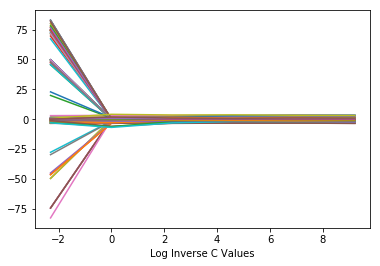

In [29]:
import pandas as pd
#Organizing the list in an easy to comprehend dictionary
classifiers = 4
params = 7
index = 0 

weight_dict = {}
perf_dict = {}

for reg in regularization_list:
    for opt in optimization_list:
        temp_list = []
        perf_list = [] 
        for c in c_list:
            temp_list.append(weights[index])
            perf_list.append(results[index])
            index += 1
        weight_dict[str(reg)+","+str(opt)] = temp_list
        perf_dict["L"+str(reg)+","+str(opt)] = perf_list
        #Merging all the params together into a vertical matrix
        for row in range(classifiers):
            for param in range(params):
                #print (temp_list[0])
                weight_dict["L"+str(reg)+","+str(opt)+",Class:"+str(row)+",Param:"+str(param)] = [x[row][param] for x in temp_list]

df = pd.DataFrame(weight_dict)
df['Log Inverse C Values'] = [np.log(1/x) for x in c_list]
df.plot(x='Log Inverse C Values',legend=False)
plt.show()


We will view how each method performs for each regularization:

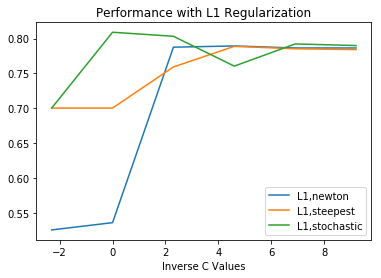

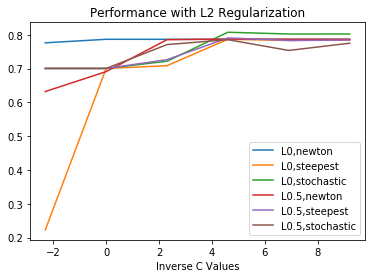

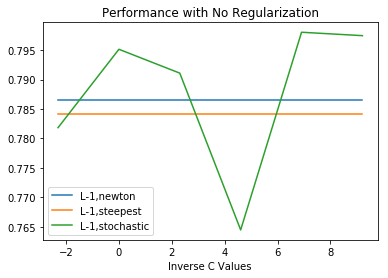

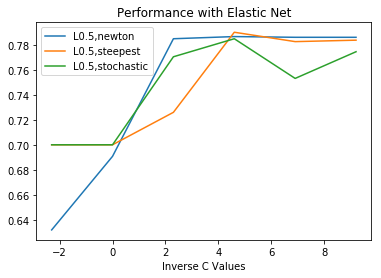

In [31]:
##L1 Regularization

df_performance = pd.DataFrame(perf_dict)
df_perf = df_performance[[col for col in df_performance if col.startswith('L1')]]
df_perf['Inverse C Values'] = [np.log(1/x) for x in c_list]
df_perf.plot(x='Inverse C Values')
plt.title("Performance with L1 Regularization")
plt.show()

##L2 Regularization

df_performance = pd.DataFrame(perf_dict)
df_perf = df_performance[[col for col in df_performance if col.startswith('L0')]]
df_perf['Inverse C Values'] = [np.log(1/x) for x in c_list]
df_perf.plot(x='Inverse C Values')
plt.title("Performance with L2 Regularization")
plt.show()

##No Regularization

df_performance = pd.DataFrame(perf_dict)
df_perf = df_performance[[col for col in df_performance if col.startswith('L-1')]]
df_perf['Inverse C Values'] = [np.log(1/x) for x in c_list]
df_perf.plot(x='Inverse C Values')
plt.title("Performance with No Regularization")
plt.show()

##Elastic Regularization

df_performance = pd.DataFrame(perf_dict)
df_perf = df_performance[[col for col in df_performance if col.startswith('L0.5')]]
df_perf['Inverse C Values'] = [np.log(1/x) for x in c_list]
df_perf.plot(x='Inverse C Values')
plt.title("Performance with Elastic Net")
plt.show()